In [10]:
!pip install opencv-python numpy mediapipe google-colab SpeechRecognition pyaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyaudio
Failed to build pyaudio
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyaudio)


In [12]:
!pip install speechrecognition

  Using cached SpeechRecognition-3.14.1-py3-none-any.whl.metadata (31 kB)
Using cached SpeechRecognition-3.14.1-py3-none-any.whl (32.9 MB)


In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 44.2 MB/s eta 0:00:00


In [15]:
import io
import os
import cv2
import PIL.Image
import time
import numpy as np
import mediapipe as mp
import speech_recognition as sr
import time
from google.colab.patches import cv2_imshow
from google.colab import files

In [16]:
from IPython.display import display, Javascript
from base64 import b64decode

In [17]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.7)

# Initialize MediaPipe Face Mesh for real-time face effects
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

In [18]:
def cartoonize_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    edges = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)
    color = cv2.bilateralFilter(img, 9, 250, 250)
    cartoon = cv2.bitwise_and(color, color, mask=edges)
    return cartoon

In [19]:
def apply_sepia(img):
    kernel = np.array([[0.272, 0.534, 0.131],
                       [0.349, 0.686, 0.168],
                       [0.393, 0.769, 0.189]])
    return cv2.transform(img, kernel)

In [20]:
def apply_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [21]:
def apply_blur(img):
    return cv2.GaussianBlur(img, (15, 15), 0)

In [22]:
def apply_sketch(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    inverted = cv2.bitwise_not(gray)
    blurred = cv2.GaussianBlur(inverted, (21, 21), 0)
    inverted_blurred = cv2.bitwise_not(blurred)
    return cv2.divide(gray, inverted_blurred, scale=256.0)

In [23]:
def apply_face_filter(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0])
                cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)
    return frame

In [24]:
def detect_gesture(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    num_fingers = 0
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
            index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
            middle_tip = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP]
            ring_tip = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP]
            pinky_tip = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP]

            if index_tip.y < thumb_tip.y: num_fingers += 1
            if middle_tip.y < thumb_tip.y: num_fingers += 1
            if ring_tip.y < thumb_tip.y: num_fingers += 1
            if pinky_tip.y < thumb_tip.y: num_fingers += 1

    return num_fingers

In [25]:
def listen_for_filter():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("Say the filter name...")
        audio = recognizer.listen(source)

    try:
        command = recognizer.recognize_google(audio).lower()
        return command
    except sr.UnknownValueError:
        return None

In [26]:
def process_frame(image, filter_type):
    if filter_type == 'gray':
        return apply_grayscale(image)
    elif filter_type == 'sepia':
        return apply_sepia(image)
    elif filter_type == 'blur':
        return apply_blur(image)
    elif filter_type == 'sketch':
        return apply_sketch(image)
    elif filter_type == 'cartoon':
        return cartoonize_image(image)
    elif filter_type == 'face_filter':
        return apply_face_filter(image)
    return image

Saving dfd.jpg to dfd (1).jpg
Enter filter (gray, sepia, blur, sketch, cartoon, face_filter): cartoon


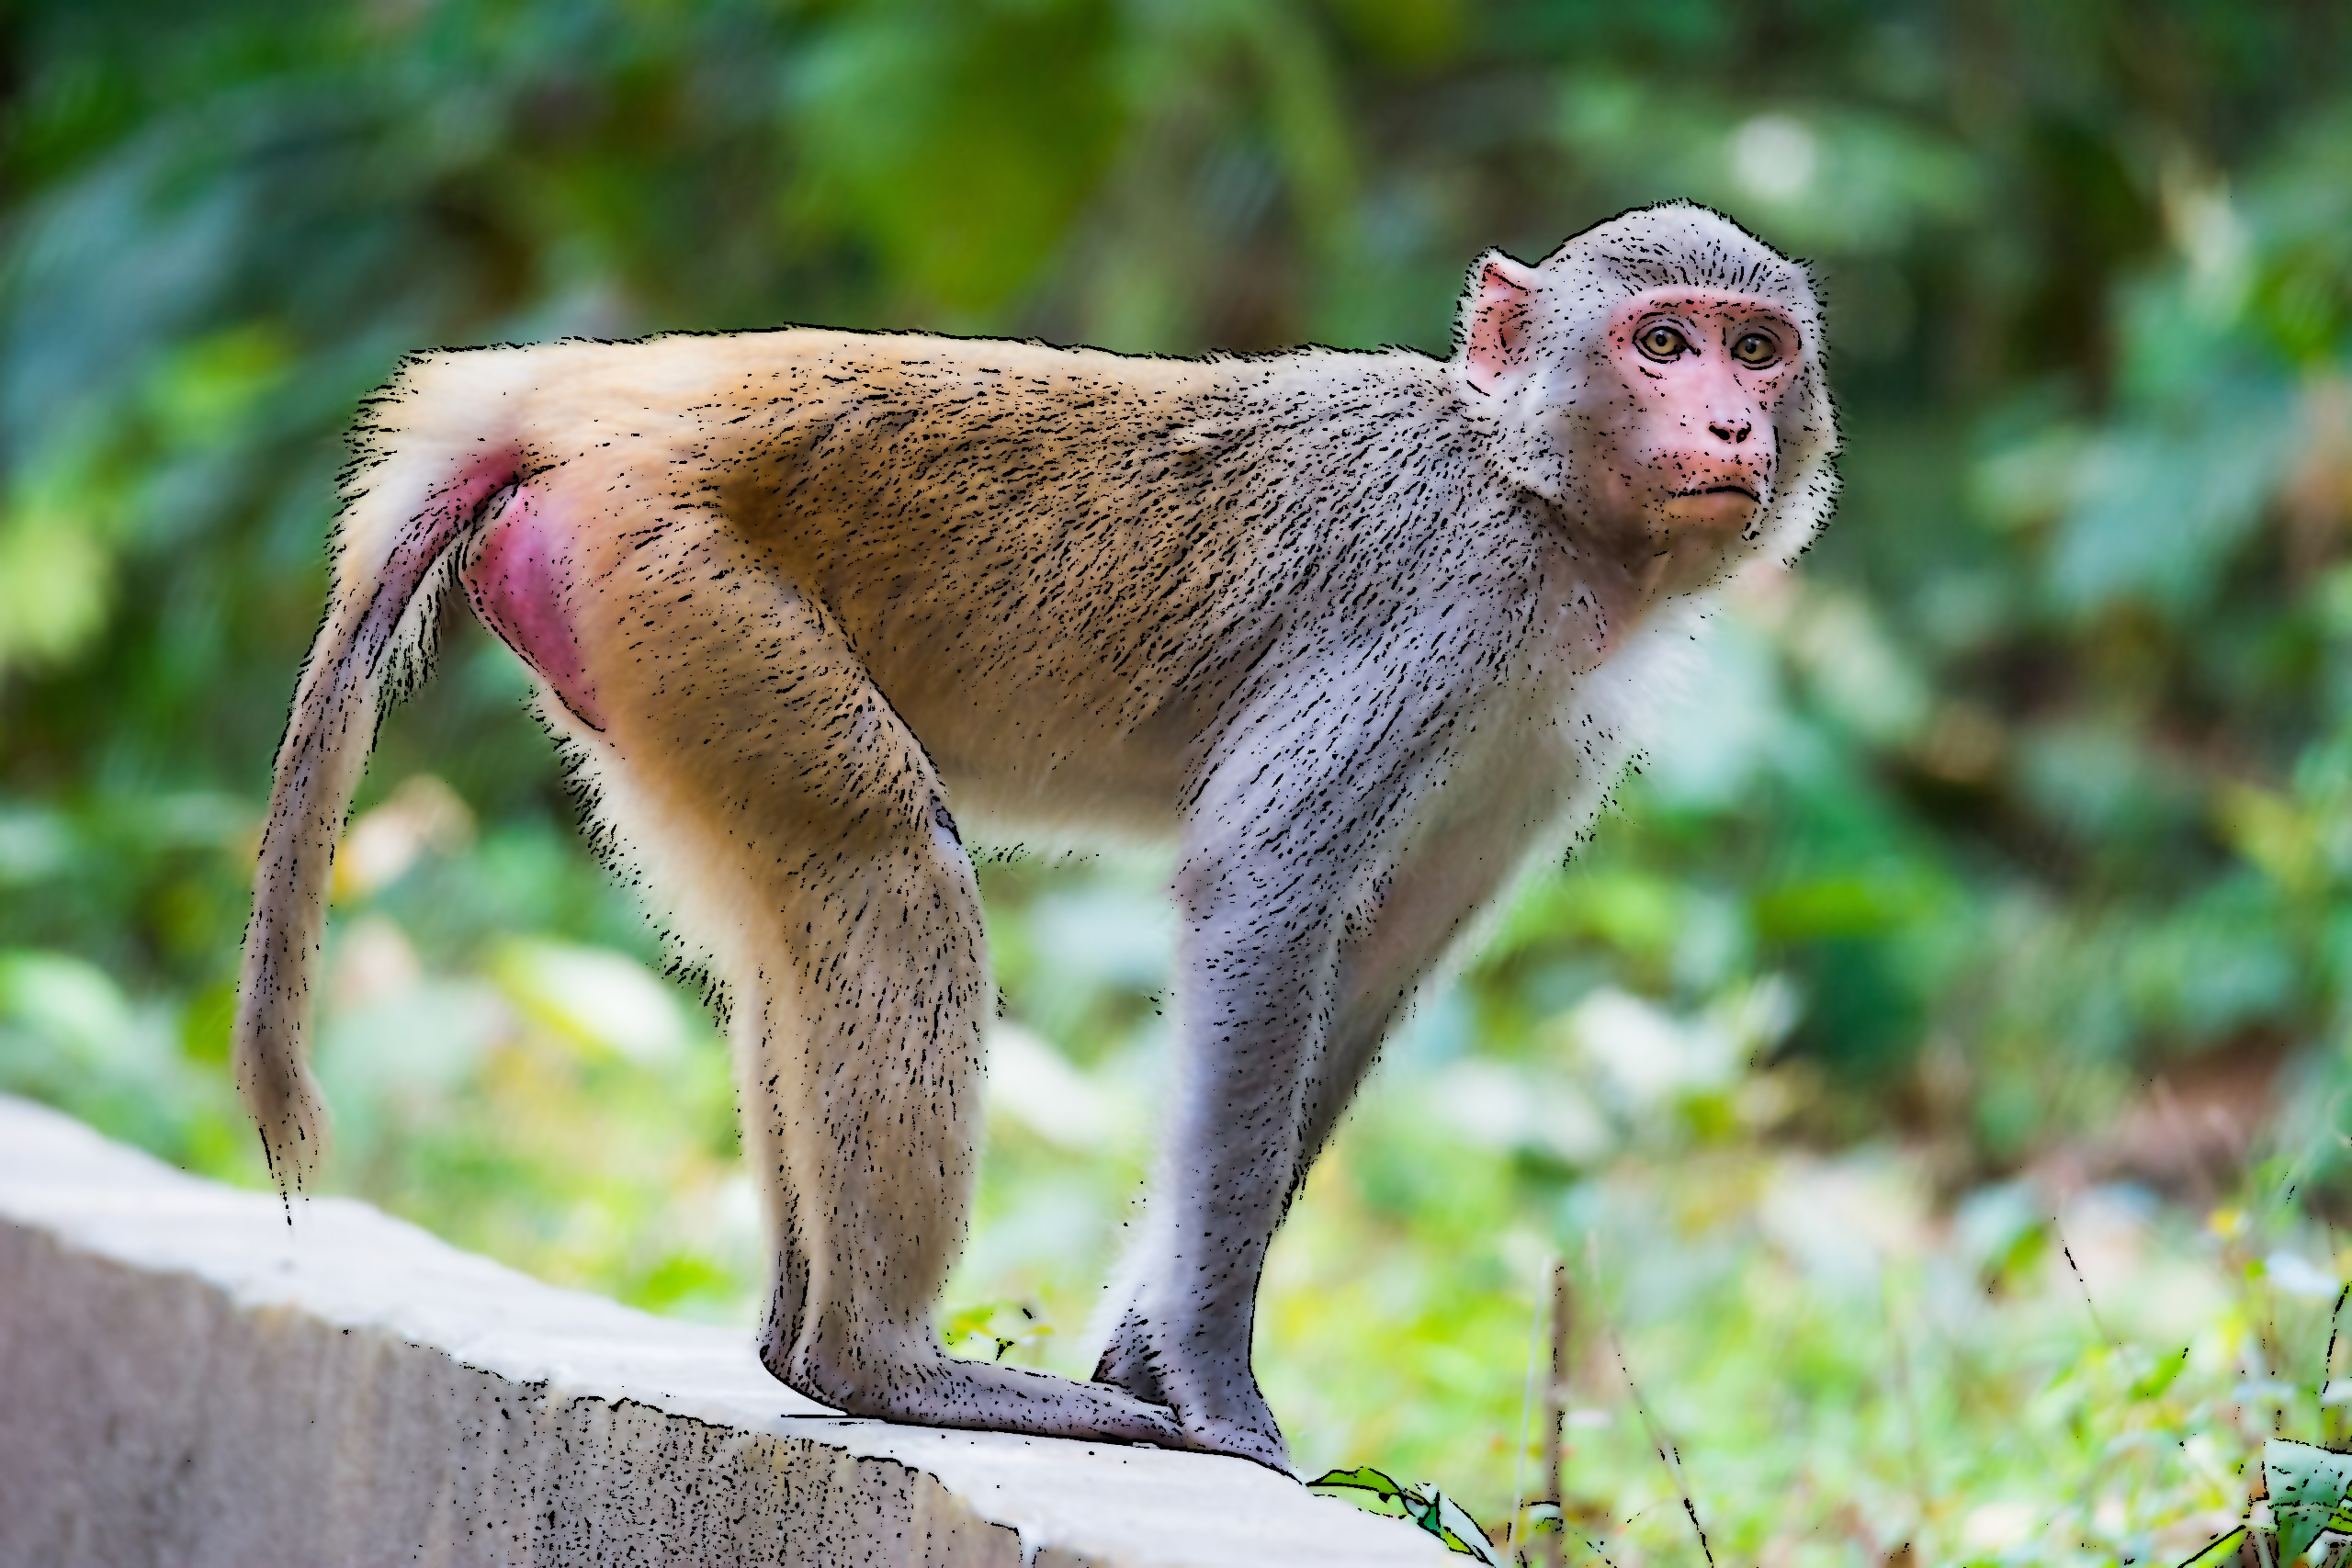

In [29]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
frame = cv2.imread(image_path)

filter_name = input("Enter filter (gray, sepia, blur, sketch, cartoon, face_filter): ")
processed_frame = process_frame(frame, filter_name)
cv2_imshow(processed_frame)

In [30]:
def record_video(duration=5, filter_type='gray'):
    cap = cv2.VideoCapture(0)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

    start_time = time.time()
    while time.time() - start_time < duration:
        ret, frame = cap.read()
        if not ret:
            break
        frame = process_frame(frame, filter_type)
        out.write(frame)

    cap.release()
    out.release()
    files.download('output.avi')

In [31]:
# Helper function to capture video from Colab
def take_photo():
    display(Javascript('''
        async function takePhoto() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => (video.onloadedmetadata = resolve));
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);

            stream.getTracks().forEach((track) => track.stop());
            video.remove();

            const dataUrl = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.capture_photo', [dataUrl], {});
        }
        takePhoto();
    '''))

def capture_photo(dataUrl):
    header, encoded = dataUrl.split(',', 1)
    data = b64decode(encoded)
    image_path = '/content/photo.jpg'
    with open(image_path, 'wb') as f:
        f.write(data)
    return image_path

In [32]:
import google.colab.output

In [33]:
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

Running in Google Colab


In [34]:
google.colab.output.register_callback('notebook.capture_photo', capture_photo)

def process_frame(image_path, filter_type):
    frame = cv2.imread(image_path)
    if frame is None:
        print("Failed to load image.")
        return
    frame = cv2.flip(frame, 1)

    if filter_type == 'gray':
        result = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    elif filter_type == 'blur':
        result = cv2.GaussianBlur(frame, (15, 15), 0)
    elif filter_type == 'canny':
        result = cv2.Canny(frame, 80, 150)
    elif filter_type == 'invert':
        result = cv2.bitwise_not(frame)
    elif filter_type == 'sepia':
        kernel = np.array([[0.272, 0.534, 0.131],
                           [0.349, 0.686, 0.168],
                           [0.393, 0.769, 0.189]])
        result = cv2.transform(frame, kernel)
    else:
        result = frame

    cv2_imshow(result)

def main():
    print("Taking photo...")
    take_photo()
    time.sleep(5)  # Wait for the image to be captured
    image_path = '/content/photo.jpg'

    if os.path.exists(image_path):
        print("Photo captured. Applying filter...")
        process_frame(image_path, 'gray')  # Change filter as needed
    else:
        print("No image found. Try again.")

main()

Taking photo...


<IPython.core.display.Javascript object>

No image found. Try again.
